In [1]:
# IMPORTS
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from skl2onnx import to_onnx
import onnxruntime as ort
import mlflow
import numpy as np
import graphviz

mlflow.sklearn.autolog()

In [2]:
df: pd.DataFrame = pd.read_csv('data/raw/Iris.csv')

In [3]:
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
X: pd.DataFrame = df[['SepalLengthCm', 'SepalWidthCm','PetalLengthCm','PetalWidthCm']]
y: pd.DataFrame = df['Species']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [6]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('algo', RandomForestClassifier(random_state=42))
])

In [7]:
model.fit(X_train, y_train)

2024/08/14 14:04:08 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c8d229f7598344c5946421168256a7a4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/08/14 14:04:15 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/homebrew/Caskroom/miniconda/base/envs/iris-classification/lib/python3.9/site-packages/_distutils_hack/__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml"
2024/08/14 14:04:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run glamorous-dog-898 at: https://dagshub.com/izzalDev/iris-classification.mlflow/#/experiments/0/runs/c8d229f7598344c5946421168256a7a4.
2024/08/14 14:04:19 INFO mlflow.tracking._t

Pipeline(steps=[('scaler', StandardScaler()),
                ('algo', RandomForestClassifier(random_state=42))])

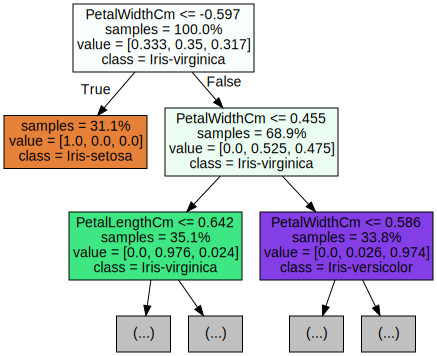

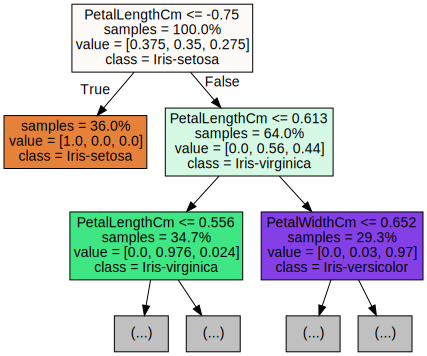

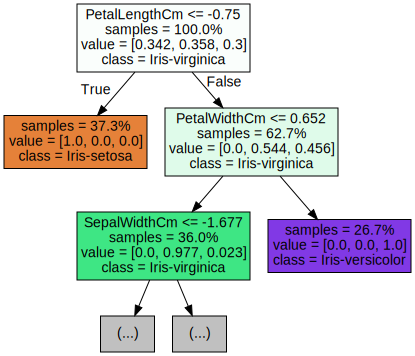

In [8]:
import matplotlib.pyplot as plt
import graphviz
from sklearn.tree import export_graphviz
from io import BytesIO
from PIL import Image

for i in range(3):
    tree = model['algo'].estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,
                               class_names=y_train.unique(),  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)

    graph = graphviz.Source(dot_data)
    display(graph)


In [9]:
y_pred = model.predict(X_test)

In [10]:
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.82      0.90      0.86        10
 Iris-virginica       0.89      0.80      0.84        10

       accuracy                           0.90        30
      macro avg       0.90      0.90      0.90        30
   weighted avg       0.90      0.90      0.90        30



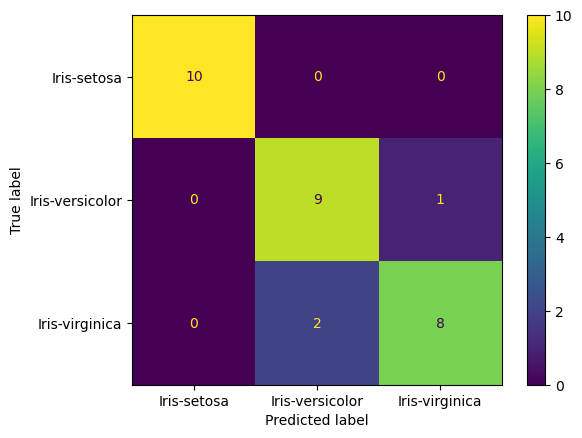

In [11]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [12]:
onnx_model = to_onnx(model, X_test[:1].to_numpy(), options={'zipmap':False})

with open('models/model.onnx', 'wb') as f:
    f.write(onnx_model.SerializeToString())

In [13]:
# SANITY CHECK

sess = ort.InferenceSession(onnx_model.SerializeToString())
input_name = sess.get_inputs()[0].name
labe_name = sess.get_outputs()[0].name
pred_onnx = sess.run([labe_name], {input_name: X_test.to_numpy()})

if (pred_onnx == y_pred).all():
    print('SUCCESS')
else:
    print('FAILURE')

SUCCESS
